First off install dependencies. This assumes that the notebook is run in the correct virtualenv.

In [ ]:
!pip install pandas numpy seaborn gpy sklearn plotly

## Rename & Repackage Data
The data was in a format I did not prefer so it is renamed and repackaged here.

In [13]:
import pandas as pd
from math import radians

def equirectangular_projection(data):
    phi = data.lat.apply(radians)
    lamb = data.lon.apply(radians)
    lamb0 = lamb.mean()
    phi0 = phi.mean()
    r = 6378000  # earth radius in m
    x = r*(phi-phi0)
    y = r*(lamb - lamb0)*cos(phi0)
    return x, y

def repackage(from_path, to_path):
    data = pd.read_pickle(from_path)
    data.timestamp = data.timestamp.apply(pd.to_datetime)
    data = data.rename(columns = {
        'latitude': 'lat',
        'longitude': 'lon',
        'journey_number': 'traj',
        'segment_number': 'seg', 
        'speed': 'speed',
        'event': 'event',
        'timestamp': 'timestamp'
    })
    
    x, y = equirectangular_projection(data)
    data['x'] = x
    data['y'] = y
    data.to_pickle(to_path)
    
    
repackage('../data/203_train.p', '../data/train3.pkl')
repackage('../data/203_test.p', '../data/test3.pkl')

In [14]:
#data = pd.read_pickle('../data/train3.pkl')
#data.head()
def mean_timestamp(timestamps):    
    return pd.to_datetime(timestamps.values.astype(np.int64).mean())

X = data.iloc[0].copy()
data.iloc[4].timestamp = 6 #
X.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data = data.drop(['timestamp', 'event', 'seg', 'station', 'line', 'traj'], axis=1).apply(np.mean, axis=0)
compressed_data['timestamp'] = mean_timestamp(data.iloc[:10].timestamp)# pd.Timestamp(2017, 1, 1, 12)
#compressed_data.timestamp = mean_timestamp(data.iloc[:10].timestamp)
compressed_data

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-02-16 03:48:40
2018-02-16 03:48:42.800000


Unnamed: 0                485.027
vehicle_id                5451.22
lon                       58.4093
lat                       15.5723
direction                  123.11
speed                      5.1206
timestamp     1518752922800000000
dtype: object

## Load training data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from IPython.display import display, clear_output
from model import learn_trajectory_model, plot_function, gamma_prior, FunctionModelPriors, TrajectoryModel, predict, compute_tau
from pandas import DataFrame

np.random.seed(12345)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 20 # len(n_trajs)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ixs = trajs.traj.unique()

## Learn normalisation functions for each segment
All trajectories must be in the same space, so normalisation is done segement-wise. This will not be Euclidian, so ARD need to be used.

In [77]:
from math import sqrt
seg_dict = dict(tuple(data.groupby('seg')))
def normalisation(seg):
    dx = seg.x.mean()
    dy = seg.y.mean()
    sd  = sqrt(max(seg.x.var(), seg.y.var()))
    def do_normalisation(data):
        data.x = (data.x - dx)/sd
        data.y = (data.y - dy)/sd
        return data
    
    return {
        'scale': do_normalisation,
        'sd': sd,
        'dx': dx,
        'dy': dy
    }
seg_norms = {
    seg_n: normalisation(seg_dict[seg_n])
    for seg_n in seg_dict
}

def normaliser_for_seg(seg_n):
    return seg_norms[seg_n] 

In [79]:
seg_n = 1
traj_n = traj_ixs[0]
seg = seg_dict[seg_n]
traj = seg[seg.traj == traj_n]
norm = normaliser_for_seg(seg_n)
norm['scale'](traj)

164.44979089000287

## Learn a model

In [83]:
from math import sqrt, cos, sin, radians

%matplotlib inline
sns.set(style="darkgrid")

def compute_time_left(data: DataFrame) -> DataFrame:
    sorted_data = data.sort_values('timestamp')
    arrival_time = sorted_data.iloc[-1].timestamp
    sorted_data['time_left'] = [
        (arrival_time - t).seconds
        for t in sorted_data.timestamp
    ]
    return sorted_data
    
def learn_model(data: DataFrame, route_n: int, seg_n: int, f_codomain) -> TrajectoryModel:
    f_priors = FunctionModelPriors(None, None, None)
    g_kern_ls_prior = None #gamma_prior(0.5, .002)
    g_kern_var_prior = None # gamma_prior(1, .5)
    g_kern_lik_prior = None
    g_priors = FunctionModelPriors(
        g_kern_ls_prior, 
        g_kern_var_prior, 
        g_kern_lik_prior)
    h_priors = FunctionModelPriors(None, None, None)

    n_restarts = 1
    D = data.shape[0]
    fix_f_likelihood = 3 / D
    n_augment_samples = 15
    augment_sigma = 4 # 5e-5
    augment_delta = 0.015 / normaliser_for_seg(seg_n)['sd']
    stop_compress_delta = 5e-3

    h_domain = ['x', 'y']
    #h_domain = ['lat', 'lon']
    return learn_trajectory_model(
        data, 
        route_n,
        seg_n,
        f_codomain, 
        h_domain,
        f_priors=f_priors,
        g_priors=g_priors,
        h_priors=h_priors,
        n_restarts=n_restarts,    
        stop_compress_delta=stop_compress_delta,
        fix_f_likelihood=fix_f_likelihood,
        n_augment_samples=n_augment_samples,
        augment_sigma=augment_sigma,
        augment_delta=augment_delta)

def plot_model(m: TrajectoryModel, data: DataFrame, f_codomain):
    n_rows = 3
    n_cols = 2
    fig_size = 8
    _fig, axs = plt.subplots(
        nrows=n_rows, 
        ncols=n_cols, 
        figsize=(
            fig_size*n_cols, 
            fig_size*n_rows
        )
    )

    # Input data
    sns.scatterplot(
        data=data, 
        x=f_codomain[0], 
        y=f_codomain[1], 
        ax=axs[0][0]
    )
    axs[0][0].set_title('Input data')
    #axs[0][0].set_aspect('equal', 'datalim')

    # h for input data
    x = data[f_codomain].values
    mean, _  = predict(m.g, x)
    progress = compute_tau(x)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': progress
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][0]
    )
    axs[1][0].set_title(r'Predicted $\tau$ of input data')
    #axs[1][0].set_aspect('equal', 'datalim')

    # Training data
    plot_function(m.g, ax=axs[0][1])
    axs[0][1].set_title(r'Inverse model function $g: (lat,lon) \mapsto \tau$')

    # H for training data
    mean, _  = m.g.model.predict(m.g.model.X)
    df = pd.DataFrame({
        'prediction': mean.T[0], 
        'progress': m.g.model.Y.flatten()
    })
    sns.scatterplot(
        data=df, 
        x='progress', 
        y='prediction', 
        ax=axs[1][1]
    )
    axs[1][1].set_title(r'Prediction $\tau$ of training data')

    # f
    plot_function(m.f, ax=axs[2][0])
    axs[2][0].set_title(r'Model function $f: \tau \mapsto (lat, lon)$')

    # h
    plot_function(m.h, ax=axs[2][1])
    axs[2][1].set_title(r'Prediction function $h: \tau \mapsto t$')

route_n = 3
seg_n = 9
traj_n = 0
normalise = normaliser_for_seg(seg_n)
seg = trajs[(trajs.traj == traj_ixs[traj_n]) & (trajs.seg == seg_n)]
timed_seg = normalise['scale'](compute_time_left(seg))
f_codomain = ['x', 'y']
m = learn_model(timed_seg, route_n, seg_n, f_codomain)
plot_model(m, timed_seg, f_codomain)
m.g.model

Optimization restart 1/1, f = -241.78436668236503


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



MemoryError: 

## Learn many models

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from model import FunctionModelPriors, learn_trajectory_model, save_model, acquire_db_conn#plot_function, gamma_prior, , predict

np.random.seed(12345)
g_domain = ['x', 'y']
n_trajs_to_learn = 5
segs = trajs[trajs.seg == seg_n]
seg_dict = dict(tuple(segs.groupby('traj')))
segs_to_learn = list(seg_dict.values())[:n_trajs_to_learn]

models = []
for seg in tqdm(segs_to_learn):
    timed_seg = compute_time_left(seg)
    m = learn_model(timed_seg, route_n, seg_n, g_domain)
    models.append(m)
    
#for m in models:
#    plot_model(m, timed_seg, f_codomain)

with acquire_db_conn() as conn:
    for m in models:
        m_id = save_model(m, conn)
        print(m_id)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Optimization restart 1/1, f = -241.78436668236463


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Optimization restart 1/1, f = -4046.422386224831


Optimization restart 1/1, f = -188.78497165396578


 20%|████████████████▊                                                                   | 1/5 [00:11<00:46, 11.56s/it]

Optimization restart 1/1, f = -173.55055776944806


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Optimization restart 1/1, f = -3829.203424251763


Optimization restart 1/1, f = -261.8000614622733


 40%|█████████████████████████████████▌                                                  | 2/5 [00:24<00:36, 12.10s/it]

Optimization restart 1/1, f = -222.31541687931443


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Optimization restart 1/1, f = -3768.803963321312


Optimization restart 1/1, f = -141.34748208522558


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:37<00:24, 12.10s/it]

Optimization restart 1/1, f = -213.6888395870359


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Optimization restart 1/1, f = -4146.869252937009


Optimization restart 1/1, f = -139.75367040342815


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:50<00:12, 12.54s/it]

Optimization restart 1/1, f = -156.81172336856758


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\pandas\core\frame.py:6211: FutureWarning:Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Optimization restart 1/1, f = -3835.706141286627


Optimization restart 1/1, f = -308.4418545604964


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.21s/it]


178
179
180
181
182


## Load many models

In [5]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from model import FunctionModel, TrajectoryModel, acquire_db_conn, load_models, compute_tau
from typing import List, Tuple
from numpy import ndarray
conn = acquire_db_conn()
with conn:
    models = load_models(route_n, seg_n, conn)

'loaded {} models'.format(len(models))

'loaded 5 models'

# Make predictions

In [10]:
from functools import reduce
from scipy.stats import norm
from collections import defaultdict

def arrival_time_prediction(models, g_domain, data):
    
    def pred_and_loglik(model: TrajectoryModel, X_obs: ndarray):
        """Returns the model prediction for the remaining arrival time
        together with the summed log likelihood of the data for the provided model.
        """
        def loglik(f: FunctionModel, tau: ndarray):
            mu, sigma = predict(f, tau.reshape(1, -1))
            return -0.5*(tau-mu)*np.linalg.inv(sigma)*(tau-mu).T \
                    -0.5*np.log(np.abs(sigma))
        
        tau, _ = predict(model.g, X_obs)
        loglik_sum = np.sum([
            loglik(model.f, t)
            for t in tau
        ])
        loglik_sum = loglik_sum
        # predict for the last point
        last_point = tau[-1].reshape(1, -1)
        prediction = predict(m.h, last_point)
        return prediction, loglik_sum
        
    def make_mixture(
        grid_res: int,
        grid_pad: int,
        preds: ndarray,
        logliks: List[float]) -> ndarray:
    
        def make_distribution(
            xx: ndarray, 
            pred: ndarray, 
            loglik: List[float]) -> ndarray:
            mean = pred[0]
            var = pred[1]
            return loglik*norm.pdf(xx, mean, np.sqrt(var))
        
        # Create grid that covers all components
        asc_preds = sorted(preds)
        smallest_pred_mean = float(asc_preds[0][0])
        smallest_pred_var = float(asc_preds[0][1])
        xmin = max(0, np.floor(smallest_pred_mean - smallest_pred_var*grid_pad))
        biggest_pred_mean = float(asc_preds[-1][0])
        biggest_pred_var = float(asc_preds[-1][1])
        xmax = np.ceil(biggest_pred_mean + biggest_pred_var*grid_pad)
        xx = np.linspace(xmin, xmax, (xmax-xmin)*grid_res)
        distributions = [
            make_distribution(xx, p, l) 
            for p, l in zip(preds, logliks) 
        ]
        
        return distributions, xx
        
    X_obs = data[g_domain].values
    preds, logliks = zip(*[
        pred_and_loglik(m, X_obs)
        for m in models
    ])
    
    # Scale to avoid numerical errors due to small numbers
    c = 1/max(logliks)
    loglik_sum = sum(logliks)
    norm_logliks = [c*l - c*loglik_sum for l in logliks]
    norm_liks = np.exp(norm_logliks)
    grid_res = 100
    grid_pad = 3
    return make_mixture(
        grid_res, grid_pad, preds, norm_liks
    )

np.random.seed(12345)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 20 # len(n_trajs)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
traj_ixs = trajs.traj.unique()


seg_sizes = [.2, .4, .6, .8]
mape = {s: defaultdict(dict) for s in seg_sizes}
mae =  {s: defaultdict(dict) for s in seg_sizes}
#segs = dict(tuple(data[data.seg = seg_n].groupby('seg')))

traj = trajs[trajs.traj == traj_ixs[0]]
seg = traj[traj.seg == seg_n]
r = 0.8
n = int(np.round(r*seg.shape[0]))
timed_seg = compute_time_left(seg).iloc[:n]
arrival_time = timed_seg.iloc[-1].time_left
g_domain = ['x', 'y']
distributions, xx = arrival_time_prediction(
    models, g_domain, timed_seg
)

# Plot results

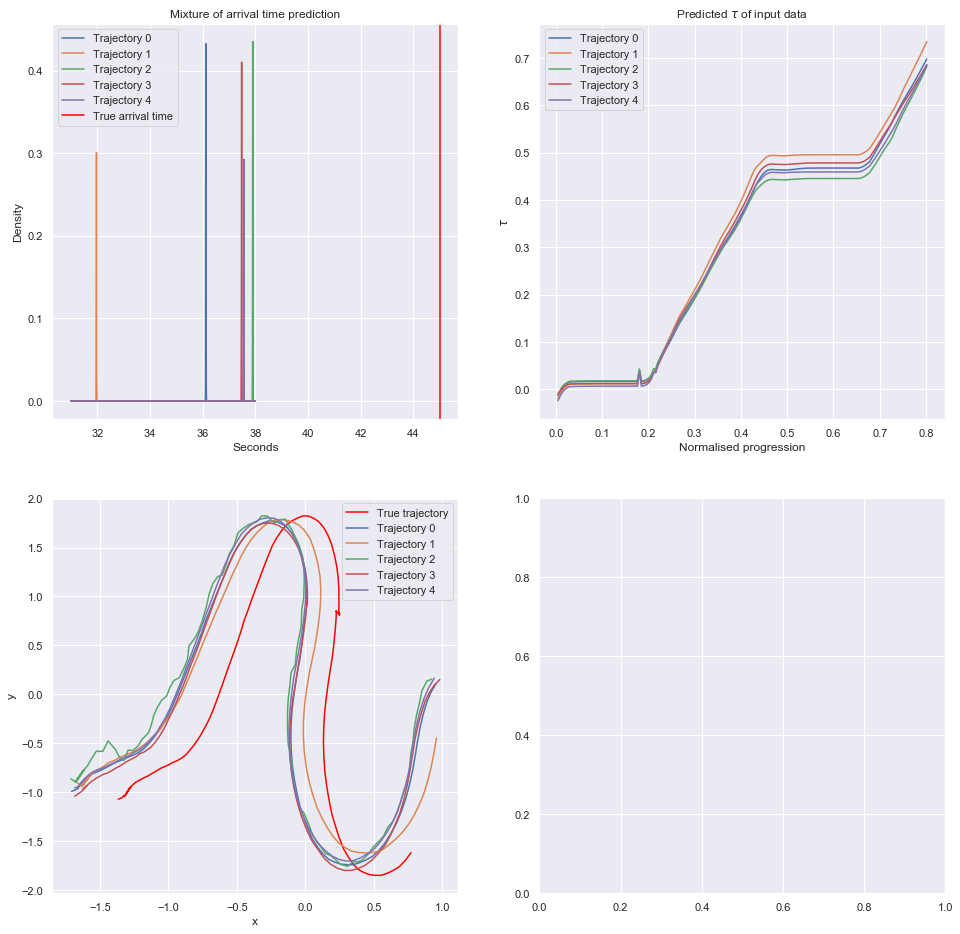

In [11]:
# Plotting results
from sklearn.preprocessing import StandardScaler

def plot_results(models, distributions, xx, seg, timed_seg, arrival_time, r):
    n_rows = 2
    n_cols = 2
    fig_size = 8
    _fig, axs = plt.subplots(
        nrows=n_rows, 
        ncols=n_cols, 
        figsize=(
            fig_size*n_cols, 
            fig_size*n_rows
        )
    )

    for i, dist in enumerate(distributions):
        axs[0][0].plot(
            xx, dist.reshape(xx.shape), label='Trajectory ' + str(i))

    axs[0][0].set_title('Mixture of arrival time prediction')
    axs[0][0].set_xlabel('Seconds')
    axs[0][0].set_ylabel('Density')
    axs[0][0].axvline(x=arrival_time, color='red', label='True arrival time')
    axs[0][0].legend()

    d = seg[g_domain]
    scaler = StandardScaler()
    scaler.fit(d)
    scaled_seg = scaler.transform(d)
    axs[1][0].plot(
        scaled_seg[:timed_seg.shape[0],0], 
        scaled_seg[:timed_seg.shape[0]:,1], 
        label='True trajectory',
        color='red'
    )
    for i, m in enumerate(models):
        # Compute tau for whole traj, then remove all from the future
        progress = compute_tau(seg)
        progress = progress[:timed_seg.shape[0]]
        mean, _  = predict(m.g, timed_seg[g_domain].values)
        axs[0][1].plot(progress, mean.T[0], label='Trajectory ' + str(i))
        axs[0][1].set_title(r'Predicted $\tau$ of input data')
        axs[0][1].set_xlabel('Normalised progression')
        axs[0][1].set_ylabel(r'$\tau$')
        axs[0][1].legend()
        #axs[1].set_aspect('equal', 'datalim')

        #mean, _  = m.g.model.predict(m.g.model.X)
        #progress = m.g.model.Y.flatten()
        #axs[1][0].scatter(mean, progress)
    for i, m in enumerate(models):
        # Remove support data
        n = m.f.model.X.shape[0]
        x = m.g.model.X[:n]
        # Remove future
        x = x[:int(np.round(x.shape[0]*r))]
        axs[1][0].plot(x[:,0], x[:,1], label='Trajectory ' + str(i))

    axs[1][0].set_xlabel('x')
    axs[1][0].set_ylabel('y')
    axs[1][0].legend()   
    
    plt.show()
    
plot_results(models, distributions, xx, seg, timed_seg, arrival_time, r)

In [ ]:

for seg_i, seg_n in enumerate(segs):
    seg = segs[seg_n]
    trajs = dict(tuple(seg.groupby('traj')))
    for traj_i, traj_n in enumerate(trajs):
        f(m, h_domain, trajs[traj_n])
        model_likelihoods = [
            model_likelihood(m, h_domain, traj_data) 
            for m in models
        ]
        X = synched_traj[['tau']].values
        Y = synched_traj[['lat', 'lon']].values
        logliks = [data_loglik(lg, X, Y) for lg in lik_gps[seg_n]]
            

 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


(array([[-0.23373931]]), array([[0.0003546]]))

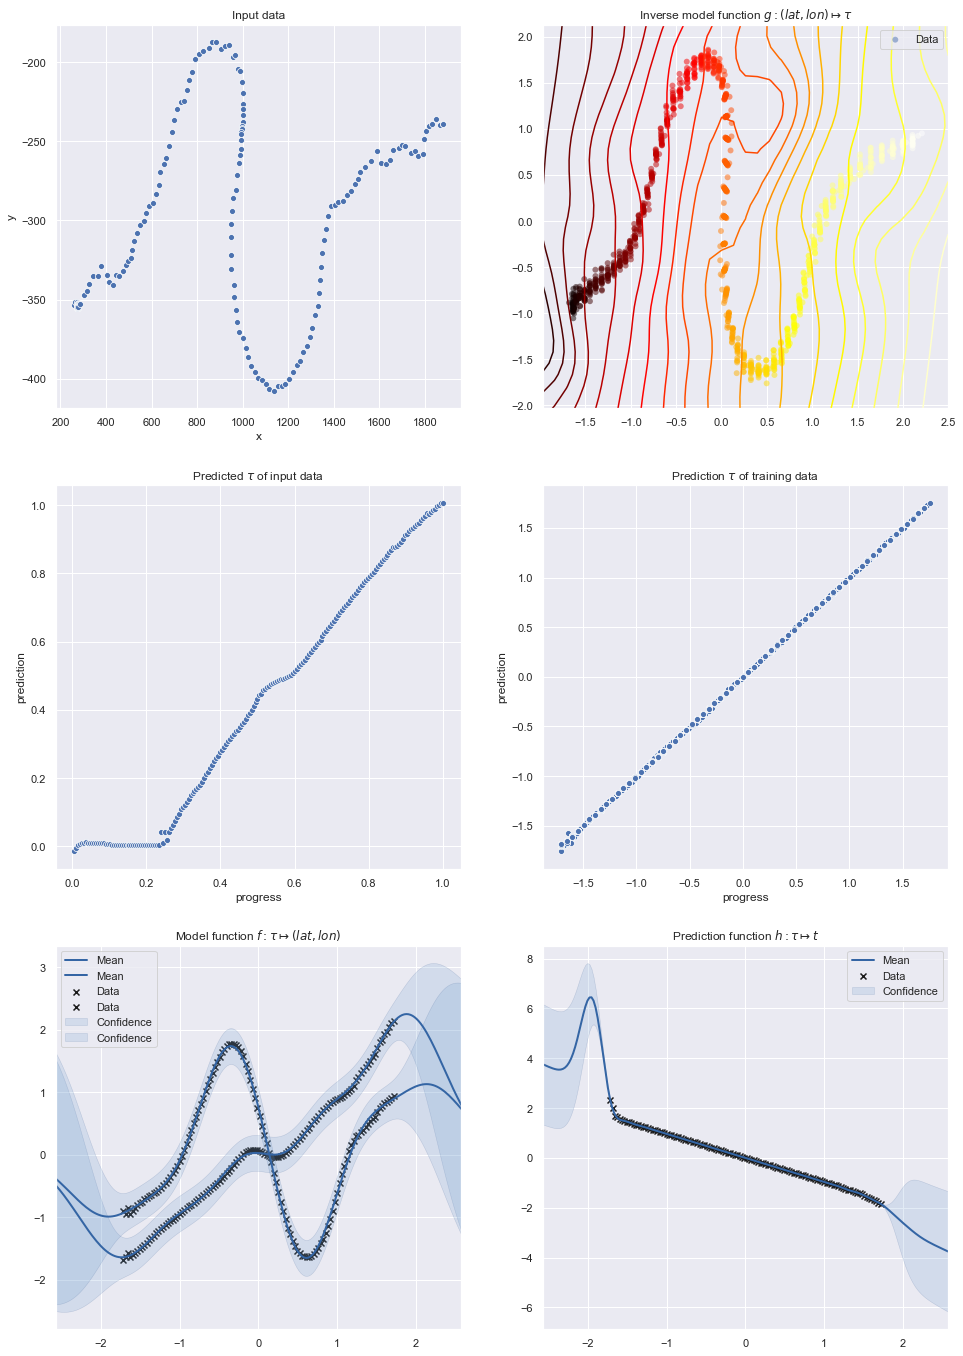

In [24]:

plot_model(models[1], timed_seg, f_codomain)

tau, _ = predict(models[1].g, timed_seg[['x', 'y']].values)
last_point = tau[-1].reshape(1, -1)
prediction = predict(models[1].h, last_point)
prediction

In [198]:
arrival_time = traj.iloc[-1].timestamp
time_left = [(arrival_time - t).seconds
             for t in traj.timestamp]
traj['time_left'] = time_left
traj
tau,_ = predict(m.g, traj[['lat', 'lon']].values)
t = predict(m.h, tau)


(array([[ 2.05612296e+02],
        [ 2.21923705e+02],
        [ 2.23328049e+02],
        [ 2.07319201e+02],
        [ 1.90367214e+02],
        [ 1.81529056e+02],
        [ 1.79583772e+02],
        [ 1.81648404e+02],
        [ 1.81648404e+02],
        [ 1.84116311e+02],
        [ 1.86319448e+02],
        [ 1.86452575e+02],
        [ 1.88059523e+02],
        [ 1.87376290e+02],
        [ 1.87918926e+02],
        [ 1.88194448e+02],
        [ 1.88472736e+02],
        [ 1.88194448e+02],
        [ 1.88194448e+02],
        [ 1.73808998e+02],
        [ 1.87646197e+02],
        [ 1.81990821e+02],
        [ 1.77226277e+02],
        [ 1.74716581e+02],
        [ 1.74091947e+02],
        [ 1.73808998e+02],
        [ 1.73808998e+02],
        [ 1.72420983e+02],
        [ 1.70312642e+02],
        [ 1.69345768e+02],
        [ 1.68346531e+02],
        [ 1.67361536e+02],
        [ 1.66520355e+02],
        [ 1.65685333e+02],
        [ 1.64838245e+02],
        [ 1.63944924e+02],
        [ 1.63066933e+02],
 

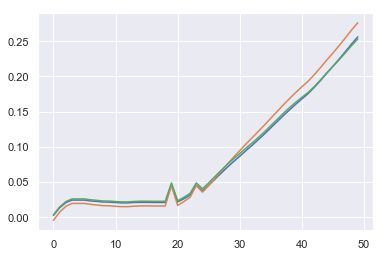

In [93]:
#experiment with why g acts up
#plot_model(models[2], timed_seg, f_codomain)
mm = models[2]

test_seg = trajs[(trajs.traj == traj_ixs[4]) & (trajs.seg == seg_n)][:50]
timed_test_seg = compute_time_left(test_seg)

for m in models:
    p, _ = predict(m.g, test_seg[f_codomain])
    plt.plot(p)

n = mm.f.model.X.shape[0]
x = mm.g.model.X[:n]
mean, _  = mm.g.model.predict(x) #mm.g.model.predict(np.ndarray(compute_tau(timed_seg)))
tau = compute_tau(x)
df = pd.DataFrame({
    'prediction': mean.T[0], 
    'progress': tau
})
#sns.scatterplot(
#    data=df, 
#    x='progress', 
#    y='prediction', 
#)
#axs[1][1].set_title(r'Prediction $\tau$ of training data')


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\figure.py:2362: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


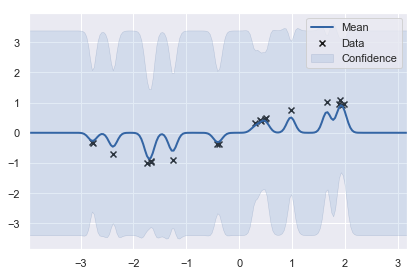

In [47]:
import GPy
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05
kernel = GPy.kern.RBF(input_dim=1, variance=2., lengthscale=.08)
m = GPy.models.GPRegression(X,Y,kernel)
#m.optimize()
fig = m.plot()
#GPy.plotting.show(fig, filename='basic_gp_regression_notebook')

In [ ]:

    def geodetic_to_ltp(X0, lat0, lon0, X, h):
        """Computes the LTP representation of the provided X = [lat, lon].T, in system with origin X0.
        Notation and math from http://archive.psas.pdx.edu/CoordinateSystem/Latitude_to_LocalTangent.pdf
        """
        a = 6378137.0     # earth semimajor axis, metres
        b = 6356752.3142  # earch semiminor axis, metres
        f = (a - b) / a   # ellipsoid flatness
        e = sqrt(f*(2-f)) # eccentricity

        def geodetic_to_ecef(lat, lon):
            N = a / sqrt(1 - (e**2 * sin(lat)**2))
            return np.array([
                (h + N)*cos(lat)*cos(lon),
                (h + N)*cos(lat)*sin(lon),
                (h + (1 - e**2) * N)*sin(lat),
            ])

        X_ecef = np.apply_along_axis(lambda x: geodetic_to_ecef(x[0], x[1]) - X0, 0, X)

        # To LTP
        R = np.array([
            [ -sin(lon0),            cos(lon0),           0         ],
            [ -cos(lon0)*sin(lat0), -sin(lat0)*sin(lon0), cos(lat0) ],
            [  cos(lat0)*cos(lon0),  cos(lat0)*sin(lon0), sin(lat0) ],
        ])
        
        return R.dot(X_ecef)
